In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('pretty')
%matplotlib inline

## Model code

In [2]:
def simulate_circuit(tmax, I_s, I_n, w=1, a_n=1, a_s1=1, a_s2=1, tau_s=10, tau_n=10, tau_p=50, b=1, bias=0,
                     act_SOM=0, act_NDNF=0):
    
    dt = 1
    t = np.arange(0, tmax, dt)
    nt = len(t)
    
    r_s = np.zeros(nt)
    r_n = np.zeros(nt)
    p = np.zeros(nt)
    p[0] = 0.73
    r_n[0] = 2+bias
    r_s[0] = 2
    
    stim_s = np.zeros(nt)
    stim_n = np.zeros(nt)
    
    act_t_start, act_t_stop = 200, 250
    if act_SOM:
        stim_s[act_t_start:act_t_stop] = act_SOM
    elif act_NDNF:
        stim_n[act_t_start:act_t_stop] = act_NDNF
    stim_s += I_s
    stim_n += I_n
    
    for i in range(1, nt):
        
        r_s[i] = r_s[i-1] + (-r_s[i-1] + stim_s[i])*dt/tau_s
        
        r_n[i] = r_n[i-1] + (-r_n[i-1] + stim_n[i] - w*p[i-1]*r_s[i-1])*dt/tau_n
        
        p[i] = p[i-1] + (-p[i-1] + p_func(r_n[i-1], b=b))*dt/tau_p
        
        r_s[i] = np.maximum(r_s[i], 0)
        r_n[i] = np.maximum(r_n[i], 0)
        p[i] = np.maximum(p[i], 0)
        
    return t, r_s, r_n, p
        
def p_func(x, b=1, sh=3):
    
#     return 1-0.1*x  #(linear presynaptic inhibition transfer function)
    return 1-1/(1+np.exp(-b*(x-sh)))
    

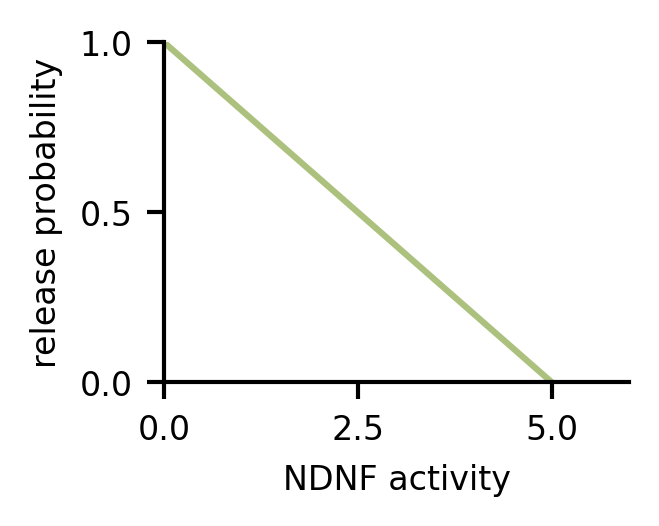

In [6]:
# plot release probability as function of NDNF activity
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300)
xx = np.arange(0, 6.1, 0.2)
ax.plot(xx, 1-0.2*xx, c='#ACC17D')
ax.set(xlim=[0, 6], ylim=[0, 1], xticks=[0, 2.5, 5], yticks=[0, 0.5, 1], xlabel='NDNF activity',
       ylabel='release probability')
plt.show()

## Measure bi-dirctional connectivity

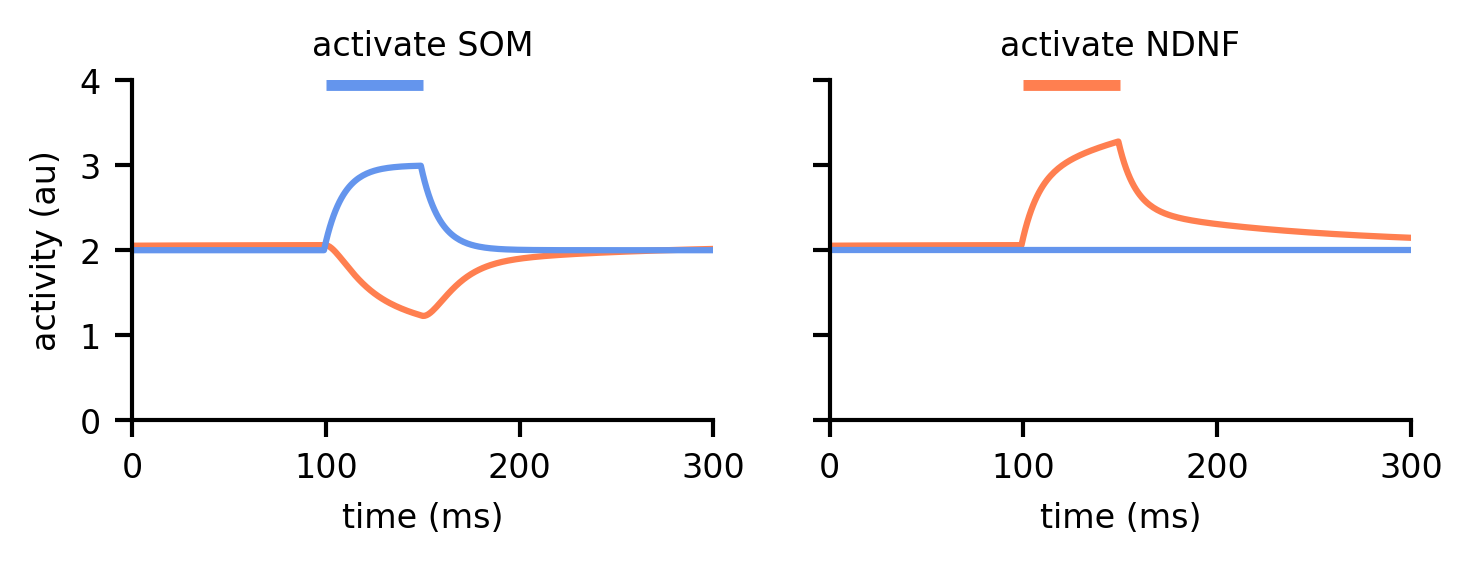

In [3]:
# activate SOM and NDNF
input_SOM = 2
input_NDNF = 3.5
t1, r_s_SOMact, r_n_SOMact, _ = simulate_circuit(400, input_SOM, input_NDNF, act_SOM=1)
t1, r_s_NDNFact, r_n_NDNFact, _ = simulate_circuit(400, input_SOM, input_NDNF, act_NDNF=1)

# plotting
csom, cndnf = 'cornflowerblue', 'coral'
fig1, ax1 = plt.subplots(1, 2, dpi=300, figsize=(5.5, 1.5), sharey=True)
t1-=100 # remove first 100 ms from plot
ax1[0].plot(t1, r_n_SOMact, c=cndnf)
ax1[0].plot(t1, r_s_SOMact, c=csom)
ax1[1].plot(t1, r_n_NDNFact, c=cndnf)
ax1[1].plot(t1, r_s_NDNFact, c=csom)
ax1[0].hlines(4, 100, 150, linewidth=5, color=csom)
ax1[1].hlines(4, 100, 150, linewidth=5, color=cndnf)
ax1[0].set(ylim=[0, 4], xlabel='time (ms)', ylabel='activity (au)', title='activate SOM', xlim=[0, 300])
ax1[1].set(xlabel='time (ms)', title='activate NDNF', xlim=[0, 300])
plt.show()

## Layer-specific outputs

In [4]:
inputs_SOM = np.arange(1, 5.1, 1.5)
inputs_NDNF = np.arange(0, 6.1, 0.2)

In [6]:
w = 1
plot_runs = False
m, n = len(inputs_SOM), len(inputs_NDNF)
som1 = np.zeros((n, m))
som2 = np.zeros((n, m))
ndnf = np.zeros((n, m))

# som1_bias = np.zeros((n, m))
# som2_bias = np.zeros((n, m))
# ndnf_bias = np.zeros((n, m))

fig, ax = plt.subplots(n, m, dpi=150, figsize=(8, 8), sharex=True, sharey=True) if plot_runs else None, None
for ii, In in enumerate(inputs_NDNF):
    for jj, Is in enumerate(inputs_SOM):
        time, rate_SOM, rate_NDNF, p = simulate_circuit(500, Is, In, w=w, tau_p=20)
        
        som1[ii, jj] = rate_SOM[-1]*p[-1]
        som2[ii, jj] = rate_SOM[-1]
        ndnf[ii, jj] = rate_NDNF[-1]
        if plot_runs:
            ax[ii, jj].plot(time, rate_SOM)
            ax[ii, jj].plot(time, rate_NDNF)
            ax[ii, jj].plot(time, p*rate_SOM)
        
#         time, rate_SOM, rate_NDNF, p = get_output(500, Is, In, w=w, tau_p=20, bias=5)
#         som1_bias[ii, jj] = rate_SOM[-1]*p[-1]
#         som2_bias[ii, jj] = rate_SOM[-1]
#         ndnf_bias[ii, jj] = rate_NDNF[-1]
        

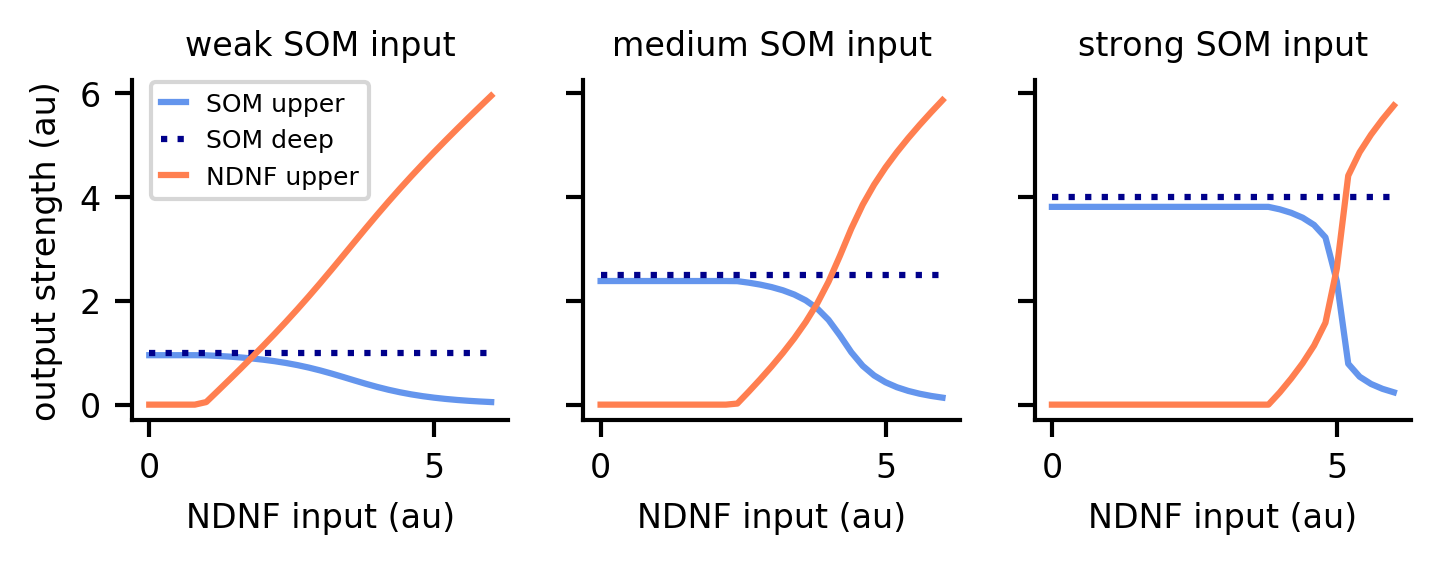

In [9]:
fig2, ax2 = plt.subplots(1, m, figsize=(5.5, 1.5), dpi=300, sharey=True)
str_ndnf = ['weak', 'medium', 'strong']
for ii in range(m):
    ax2[ii].plot(inputs_NDNF, som1[:,ii], c=csom, label='SOM upper')
    ax2[ii].plot(inputs_NDNF, som2[:,ii], ':', c='darkblue', label='SOM deep')
    ax2[ii].plot(inputs_NDNF, ndnf[:,ii], c=cndnf, label='NDNF upper')
#     ax2[ii].plot(inputs_NDNF, ndnf[:,ii]+som1[:,ii], c='gray', alpha=0.8, label='total L1')
    ax2[ii].set(xlabel='NDNF input (au)', title=f"{str_ndnf[ii]} SOM input", xticks=[0, 5])
ax2[0].set(ylabel='output strength (au)')
ax2[0].legend(loc=(0.05, 0.65), handlelength=1, fontsize=6)
plt.show()

## 2d plots of activities and outputs

NameError: name 'inputs' is not defined

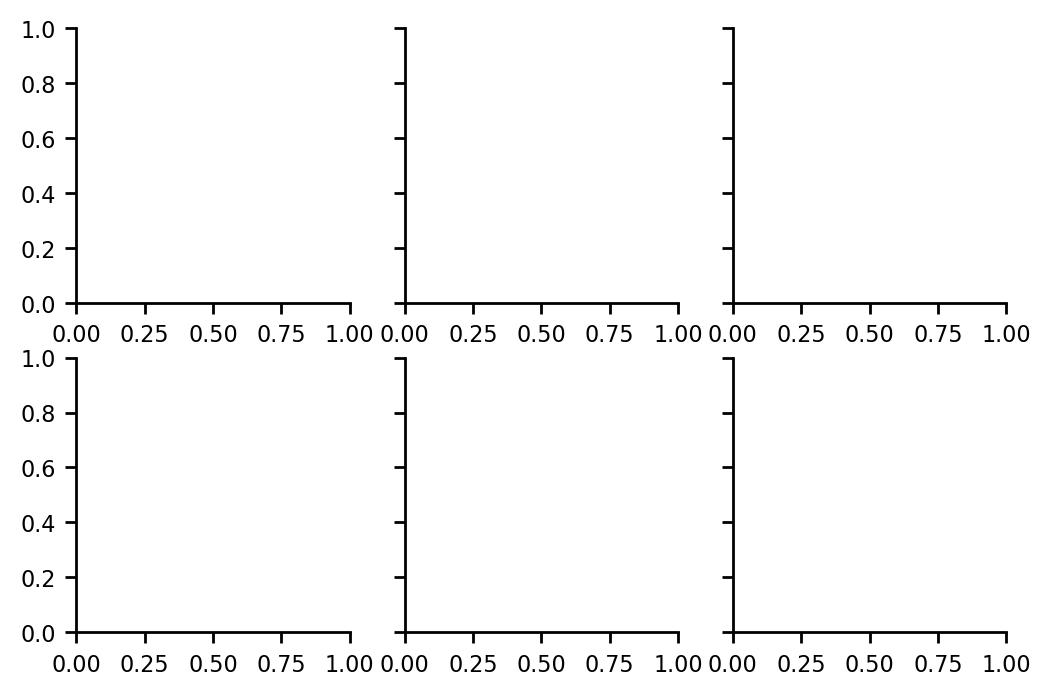

In [10]:
fig, ax2 = plt.subplots(2, 3, figsize=(6,4), dpi=200, sharey=True, gridspec_kw={'width_ratios':[1, 1, 1]})
ax2[0,0].pcolormesh(inputs, inputs, ndnf, vmin=0, vmax=8)
ax2[0,1].pcolormesh(inputs, inputs, som1, vmin=0, vmax=8)
cb = ax2[0,2].pcolormesh(inputs, inputs, som2, vmin=0, vmax=8)
ax2[1,0].pcolormesh(inputs, inputs, ndnf_bias, vmin=0, vmax=8)
ax2[1,1].pcolormesh(inputs, inputs, som1_bias, vmin=0, vmax=8)
cb = ax2[1,2].pcolormesh(inputs, inputs, som2_bias, vmin=0, vmax=8)
cax = ax2[0,2].inset_axes([1.02, 0, 0.1, 1], transform=ax2[0,2].transAxes)
#     cbar = fig.colorbar(pcm, ax=ax_e, cax=cax, ticks=[0, 0.5])
plt.colorbar(cb, ax=ax2[0,2], cax=cax, label='output strength')

for axx in ax2[1]:
    axx.set(xlabel='input SOM')
ax2[0,0].set(ylabel='input NDNF', title='output NDNF')
ax2[0,1].set(title='output SOM L1')
ax2[0,2].set(title='output SOM deep')

NameError: name 'inputs' is not defined

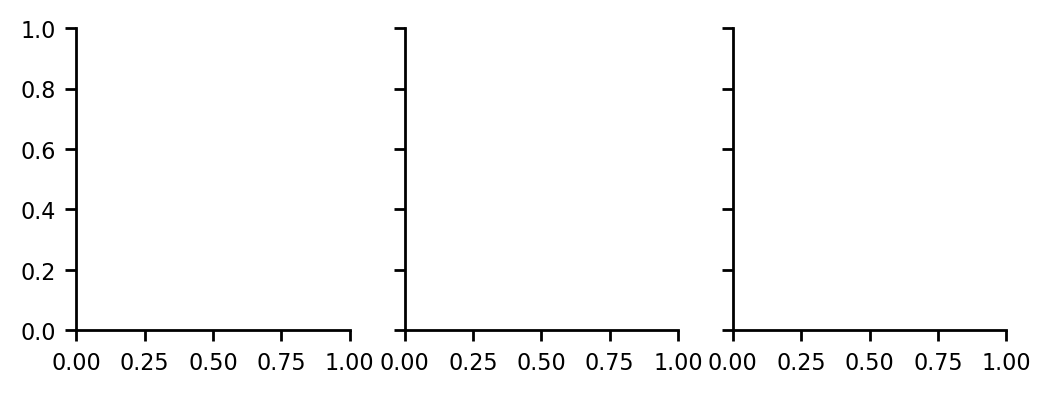

In [12]:
fig, ax2 = plt.subplots(1, 3, figsize=(6,2), dpi=200, sharey=True, gridspec_kw={'width_ratios':[1, 1, 1]})
ax2[0].pcolormesh(inputs, inputs, ndnf-ndnf_bias, vmin=-8, vmax=8, cmap='bwr')
ax2[1].pcolormesh(inputs, inputs, som1-som1_bias, vmin=-8, vmax=8, cmap='bwr')
cb = ax2[2].pcolormesh(inputs, inputs, som2-som2_bias, vmin=-8, vmax=8, cmap='bwr')
cax = ax2[2].inset_axes([1.02, 0, 0.1, 1], transform=ax2[2].transAxes)
#     cbar = fig.colorbar(pcm, ax=ax_e, cax=cax, ticks=[0, 0.5])
plt.colorbar(cb, ax=ax2[2], cax=cax)

for axx in ax2:
    axx.set(xlabel='input SOM')
ax2[0].set(ylabel='input NDNF', title='output NDNF (diff)')
ax2[1].set(title='output SOM L1 (diff)')
ax2[2].set(title='output SOM deep (diff)')

NameError: name 'inputs' is not defined

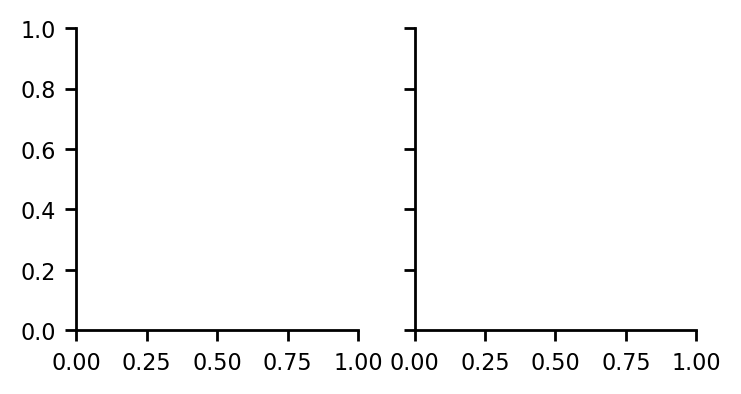

In [11]:
fig, ax3 = plt.subplots(1, 2, figsize=(4,2), sharey=True, dpi=200)
ax3[0].pcolormesh(inputs, inputs, ndnf-som1, cmap='BrBG', vmin=-8, vmax=8)
cb = ax3[1].pcolormesh(inputs, inputs, ndnf_bias-som1_bias, cmap='BrBG', vmin=-8, vmax=8)
ax3[0].set(xlabel='input SOM', ylabel='input NDNF', title='no bias')
ax3[1].set(xlabel='input SOM', title='bias to NDNF')
cax = ax3[1].inset_axes([1.02, 0, 0.1, 1], transform=ax3[1].transAxes)
plt.colorbar(cb, ax=ax3[1], cax=cax, label='(NDNF - SOM) L1 out')